## entropy

In [ ]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram
from calibrate.evaluation.ood_test_utils import entropy

if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
    # dataset_type = "mrbrains"
    # fname = "0.h5" 
    # sno = 24
    
    # dataset_type = "flare"
    # fname = "train_197.h5" 
    # sno = 19
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    dataset_type = "promise_mc"
    fname = "prostate_46.h5" 
    sno = 4
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','penalty','focal','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    # diagram = ReliabilityDiagram(bins=25, style="curve")
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:]
    
    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)
    
    plt.figure(figsize=(25,25))
    plt.subplot(1,8,1)
    plt.imshow(mask)
    plt.xticks([])
    plt.yticks([])
    plt.title('mask')

    
    ii = 2
    for key, model_path in zip(method_names,models_path):

        checkpoint = torch.load(model_path)["state_dict"]
        checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
        model.load_state_dict(checkpoint)
        model = model.to('cuda:4')

        imgT = torch.from_numpy(img)
        imgT = imgT.unsqueeze(0)
        imgT = imgT.cuda('cuda:4')

        # target = np.expand_dims(mask,axis=0)
        # targetT = torch.from_numpy(target)
        # targetT = targetT.cuda('cuda:4')

        predT = model(imgT.float()).detach().cpu() 
        entr = entropy(predT).numpy()[0]
        outputconf = F.softmax(predT,dim=1).numpy()[0]
        output = np.argmax(outputconf,axis=0)
                
        # print (outputconf.shape, label.shape, output.shape, maxconf.shape)
        plt.subplot(1,8,ii)
        # plt.imshow(outputconf[2], cmap='jet',vmin=0, vmax=1)
        plt.imshow(entr, cmap='jet',vmin=0, vmax=1)
        plt.xticks([])
        plt.yticks([])
        plt.title(key)
                    
        ii = ii + 1
        # bin_strength_plot(maxconf, output, label, key)
        
        # fig_reliab = diagram.plot(outputconf, mask)
        
        # plt.show()

## conf plot 

In [ ]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
# from calibrate.evaluation.reliability_diagram import ReliabilityDiagram
from calibrate.evaluation.ood_test_utils import entropy

if __name__ == "__main__":
    

    dataset_type = "acdc"
    fname = '223.h5'
    sno = None   
    
    # dataset_type = "mrbrains"
    # fname = "0.h5" 
    # sno = 24
    
    # dataset_type = "flare"
    # fname = "train_197.h5" 
    # sno = 19
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

#     dataset_type = "promise_mc"
#     fname = "prostate_46.h5" 
#     sno = 4
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','penalty','focal','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    # diagram = ReliabilityDiagram(bins=25, style="curve")
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:].astype(int)
    
    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)

    for cno in np.unique(mask)[1:]:
        
        plt.figure(figsize=(25,25))
        plt.subplot(1,8,1)
        plt.imshow(mask == cno)
        plt.xticks([])
        plt.yticks([])
        plt.title('mask')
        
        ii = 2
        for key, model_path in zip(method_names,models_path):

            checkpoint = torch.load(model_path)["state_dict"]
            checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
            model.load_state_dict(checkpoint)
            model = model.to('cuda:4')

            imgT = torch.from_numpy(img)
            imgT = imgT.unsqueeze(0)
            imgT = imgT.cuda('cuda:4')

            # target = np.expand_dims(mask,axis=0)
            # targetT = torch.from_numpy(target)
            # targetT = targetT.cuda('cuda:4')

            predT = model(imgT.float()).detach().cpu() 
            entr = entropy(predT).numpy()[0]
            outputconf = F.softmax(predT,dim=1).numpy()[0]
            output = np.argmax(outputconf,axis=0)

            # print (outputconf.shape, label.shape, output.shape, maxconf.shape)

            plt.subplot(1,8,ii)
            plt.imshow(outputconf[cno], cmap='jet',vmin=0, vmax=1)
            plt.xticks([])
            plt.yticks([])
            plt.title(key)

            ii = ii + 1
            # bin_strength_plot(maxconf, output, label, key)

            # fig_reliab = diagram.plot(outputconf, mask)

            # plt.show()

## dilation studies

In [ ]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
from calibrate.evaluation.metrics import ECELoss
from skimage.morphology import binary_dilation,disk

if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
    # dataset_type = "mrbrains"
    # fname = "0.h5" 
    # sno = 24
    
    dataset_type = "flare"
    fname = "train_197.h5" 
    sno = 19
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    # dataset_type = "promise_mc"
    # fname = "prostate_46.h5" 
    # sno = 4
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','penalty','focal','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    eceloss = ECELoss()
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:]
    
    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)
    
    ecedict = {'dil':[],'ece':[],'model':[]}
    plt.figure(figsize=(15,15))
    
    for jj in range(5):
        
        for key, model_path in zip(method_names,models_path):

            checkpoint = torch.load(model_path)["state_dict"]
            checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
            model.load_state_dict(checkpoint)
            model = model.to('cuda:4')

            imgT = torch.from_numpy(img)
            imgT = imgT.unsqueeze(0)
            imgT = imgT.cuda('cuda:4')
            predT = model(imgT.float()).detach().cpu() 
            maskT = torch.from_numpy(mask)
            
            n, c, x, y = predT.shape
            logits = torch.einsum("ncxy->nxyc", predT)
            logits = logits.reshape(n * x * y, -1)
            labels = maskT.reshape(n * x * y)
            index = torch.nonzero(labels != 0).squeeze()
            logits = logits[index, :]
            labels = labels[index]
            metric = round(eceloss(logits, labels).detach().cpu().numpy()[0],4)
            
            ecedict['dil'].append(jj)
            ecedict['ece'].append(metric)
            ecedict['model'].append(key)
            
        mask = binary_dilation(mask, disk(1, dtype=bool))
        plt.subplot(1,5,jj+1)
        plt.imshow(mask)
        plt.xticks([])
        plt.yticks([])
        
df = pd.DataFrame(ecedict)
plt.figure(figsize=(20,10))
for method_name in method_names:
    plt.plot(df[df['model'] == method_name].ece.to_list(),'o-')
plt.legend(method_names)

## boundaries 

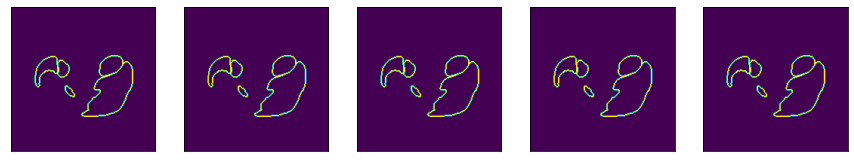

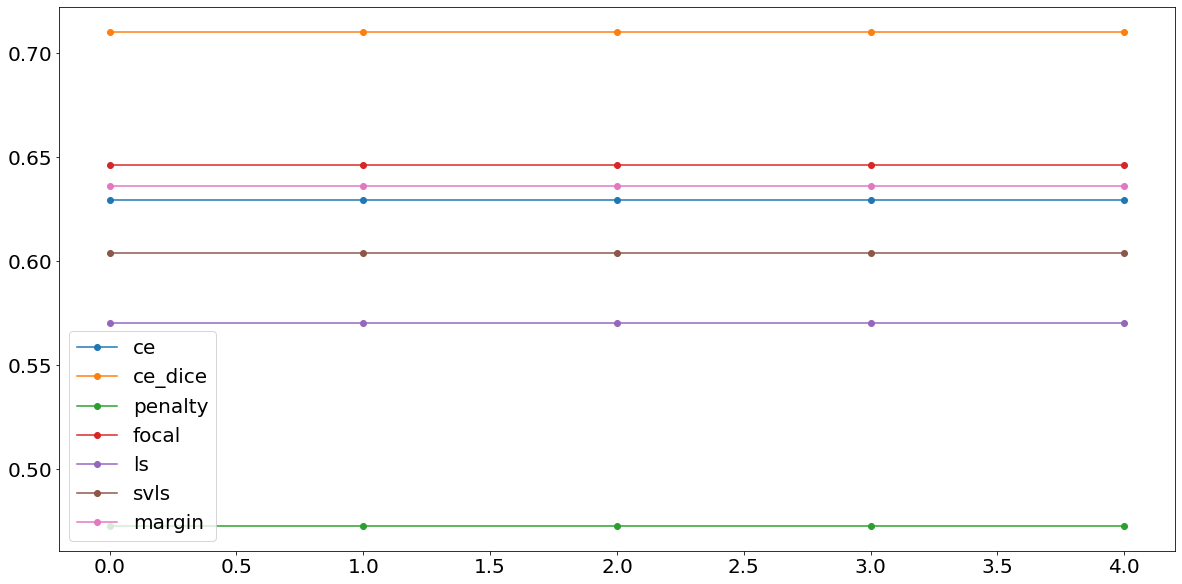

In [2]:
import glob
from calibrate.net.unet import UNet
import numpy as np
import torch
from tqdm import tqdm
import h5py
from torch.nn import functional as F
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import *
from common import *
from calibrate.evaluation.metrics import ECELoss
from skimage.morphology import binary_dilation,disk
from skimage.segmentation import find_boundaries

if __name__ == "__main__":
    

    # dataset_type = "acdc"
    # fname = '223.h5'
    # sno = None   
    
    # dataset_type = "mrbrains"
    # fname = "0.h5" 
    # sno = 24
    
    dataset_type = "flare"
    fname = "train_197.h5" 
    sno = 19
    
    # dataset_type = "brats"
    # fname = "BRATS_456.h5" 
    # sno = 6

    # dataset_type = "refuge"
    # fname = 'T0251.h5'
    # sno = None 

    # dataset_type = "promise_mc"
    # fname = "prostate_46.h5" 
    # sno = 4
    
    params = get_params(dataset_type)
    method_names =['ce','ce_dice','penalty','focal','ls','svls','margin']
    fpath = os.path.join(params.data_root,fname)
    models_path = [params.model_path_ce, params.model_path_ce_dice, params.model_path_focal, params.model_path_penalty, 
                   params.model_path_ls, params.model_path_svls, params.model_path_margin]
    model = UNet(input_channels=params.in_channels, num_classes=params.nclasses)
    
    eceloss = ECELoss()
    
    with h5py.File(fpath, 'r') as data:

        img = data["img"][:]
        mask = data["mask"][:]
    
    img, mask = pre_process_data(img, mask, dataset_type, sno=sno)
    
    ecedict = {'dil':[],'ece':[],'model':[]}
    plt.figure(figsize=(15,15))
    
    for jj in range(5):
        
        bnd = find_boundaries(mask).astype(int)
        
        for key, model_path in zip(method_names,models_path):

            checkpoint = torch.load(model_path)["state_dict"]
            checkpoint = dict((key[7:] if "module" in key else key, value)for (key, value) in checkpoint.items())
            model.load_state_dict(checkpoint)
            model = model.to('cuda:4')

            imgT = torch.from_numpy(img)
            imgT = imgT.unsqueeze(0)
            imgT = imgT.cuda('cuda:4')
            predT = model(imgT.float()).detach().cpu() 
            maskT = torch.from_numpy(bnd)
            
            n, c, x, y = predT.shape
            logits = torch.einsum("ncxy->nxyc", predT)
            logits = logits.reshape(n * x * y, -1)
            labels = maskT.reshape(n * x * y)
            index = torch.nonzero(labels != 0).squeeze()
            logits = logits[index, :]
            labels = labels[index]
            metric = round(eceloss(logits, labels).detach().cpu().numpy()[0],4)
            
            ecedict['dil'].append(jj)
            ecedict['ece'].append(metric)
            ecedict['model'].append(key)
            
        # mask = binary_dilation(mask, disk(3, dtype=bool))
        # print (np.unique(bnd))
        plt.subplot(1,5,jj+1)
        plt.imshow(bnd)
        # plt.imshow(mask)
        plt.xticks([])
        plt.yticks([])
        
df = pd.DataFrame(ecedict)
plt.figure(figsize=(20,10))
for method_name in method_names:
    plt.plot(df[df['model'] == method_name].ece.to_list(),'o-')
plt.legend(method_names)